# 主題：政治新聞資料分析
- 組員：王冠人、萬俊彥、廖品琪
- 時間：2019/01/29

## 研究目標
考量臺灣社會政治冷感的現狀，提供一個較為客觀的資料統整，藉由日常生活中的事件觀察政治人物的網路聲量變化，作為一種參與政治的方式。

## 研究方法
1. 爬蟲搜尋網路新聞
2. 進行資料清理及資料分析
4. 視覺化呈現研究結果

## 研究內容及結果

# Part I 爬蟲

- [新頭殼新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/new_talk_crawler.ipynb)
- [自由時報新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/liberty_times_crawler.ipynb)

#  Part II 資料清洗及分析

In [1]:
import os
import pickle
import jieba
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from modules import *
#設定字型
font_path = '../tools/msjh.ttc'
font = font_manager.FontProperties(fname='../tools/msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

### 載入新聞資料

In [2]:
#將資料讀黨並取出文章內容
with open('../crawler/data/new_talk.pkl', 'rb') as f:
    data = pickle.load(f)
    
data = data[::-1]
contents = [news['content'] for news in data]

In [3]:
contents

["國民黨新北市長侯友宜今 (7) 日一早精神奕奕，穿著整套騎車裝，在五名年輕同仁的陪伴下，從石門麟山鼻到三芝淺水灣，沿著自行車道欣賞碧海藍天的美景風光。雖然氣溫超過37度高溫\x15，不過因為平常就有運動習慣，侯友宜輕輕鬆鬆「完騎」七公里，還笑稱「小case啦！」\xa0侯友宜表示，北海岸金山、石門、萬里、三芝是「皇冠海岸」上的四顆鑽石，未來他當選新北市長，一定會打造更完整的北海岸自行車道，把觀光線延伸並與淡水串聯起來，善用這一條北台灣最珍貴的海岸美景。不過大田寮停車場到淺水灣這段，因為缺乏專用車道，必須進入馬路與汽機車同行，未來他也會努力克服地形障礙，讓車友擁有更高的安全度。\xa0今天剛好是侯友宜61歲生日，在「鐵馬體驗行」結束後，當地民眾特別搬出一顆大西瓜替他慶生，侯友宜切西瓜，一刀劈下、架式十足，用水果取代蛋糕慶生。侯希望更多人能夠用行動支持台灣盛產的水果，支持在地農業，同時預告明天將會協助農友行銷水果。\xa0媒體詢問文化大學「大群館」宿舍議題，侯友宜表示，這已經是五六年前的舊聞，在雙北市議會都曾有的舊聞重炒，他已經對外清楚交代過，相關問題應該由文大自己去說明比較好。侯友宜也語重心長地表示，很多人不願意出來選舉，就是因為會有各式各樣的造謠抹黑，他強調「選舉還是要好好談政見」，他強調自己「辦過無數刑案，一輩子問心無愧、坦蕩蕩，從來不擔心這些。」\xa0至於張錫銘女兒為父申冤沒想要傷害警察，侯認為整個逮捕過程甚至偵辦過程，都是公開透明，司法也對張錫銘做了審判，「我們都尊重司法。」 \r          (function(d,a){d[a]=d[a]||function(){(d[a].q=d[a].q||[]).push(arguments)};}(window,'dable'));\r          dable('renderWidget', 'dablewidget_6Xg8WqoN');\r          \r        今天剛好是侯友宜61歲生日，他以西瓜代替蛋高慶生，說騎完車吃冰涼的西瓜最舒服。\xa0\xa0\xa0圖:侯友宜競選辦公室/提供      ",
 "針對北農總經理吳音寧日前遭議員爆料用業務推廣費買洋酒送民進黨台北市黨部一事，台北市長柯文哲日前派監察人、政風處突襲北農查帳，農委會副主委陳吉仲昨（6）質疑，市政府會同相關

### 使用 coshow 找出新詞 -> 自定義辭典

In [4]:
#找出文章內容各個辭彙出現頻率
get_coshow(contents[:1000])[:10]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/hj/k0nkz_g13r39b83yqxjw2g5c0000gn/T/jieba.cache
Loading model cost 0.643 seconds.
Prefix dict has been built succesfully.


[('68', 1001),
 ('民進黨', 617),
 ('對於', 475),
 ('蔡英文', 471),
 ('柯文哲', 442),
 ('台北市長', 356),
 ('長參選人', 316),
 ('沒有', 288),
 ('今（', 261),
 ('）日', 258)]

### 設定繁體中文斷詞、載入自訂辭典、stopwords

In [5]:
#載入繁體中文詞庫
jieba.set_dictionary('../jieba_data/dict.txt.big')
jieba.load_userdict('../jieba_data/userdict.txt')
stopwords = []
#加入停用詞清單
with open('../jieba_data/stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip())
    stopwords.append(' ')

Building prefix dict from /Users/shayumin/Downloads/Political-News-Analysis-master/jieba_data/dict.txt.big ...
Loading model from cache /var/folders/hj/k0nkz_g13r39b83yqxjw2g5c0000gn/T/jieba.u899af6778d4f1817aab21cc15aad76e6.cache
Loading model cost 1.170 seconds.
Prefix dict has been built succesfully.


In [6]:
# add cutted dict to each news
#建立一個cutted_dict存段好詞的list
for i in range(len(data)):
    current_content = data[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content))
    data[i]['cutted_dict'] = lcut_to_dict(current_cutted)
    

In [7]:
#重新斷詞並拿掉停用詞
cutted_dict = get_cutted_dict(contents[:1000])
#取出出現頻率前20高的詞
high_freq_pair = first_n_words(cutted_dict, 20)
high_freq_pair

[('台灣', 1380),
 ('國民黨', 783),
 ('侯友宜', 716),
 ('柯文哲', 691),
 ('民進黨', 681),
 ('指出', 600),
 ('中國', 561),
 ('媒體', 541),
 ('選舉', 521),
 ('市府', 501),
 ('希望', 494),
 ('公司', 487),
 ('一個', 469),
 ('美國', 464),
 ('政府', 448),
 ('未來', 413),
 ('提供', 412),
 ('蘇貞昌', 388),
 ('針對', 349),
 ('國家', 337)]

In [8]:
cutted_dict = get_cutted_dict(contents)

In [9]:
# 三個字判斷可能為人名
possible_name = first_n_words(cutted_dict, 1000, 3, 3)
possible_name[:10]

[('民進黨', 8922),
 ('國民黨', 8420),
 ('柯文哲', 8153),
 ('韓國瑜', 6590),
 ('陳其邁', 4683),
 ('蔡英文', 3738),
 ('蘇貞昌', 3280),
 ('姚文智', 2973),
 ('候選人', 2946),
 ('侯友宜', 2665)]

In [10]:
# 四個字以上判斷可能為事件
possible_events = first_n_words(cutted_dict, 200, 4)
possible_events[:10]

[('台北市長柯文哲', 1590),
 ('總統蔡英文', 1356),
 ('時代力量', 1135),
 ('九二共識', 1022),
 ('行政院長賴清德', 1003),
 ('中華民國', 852),
 ('競選總部', 779),
 ('蔡英文總統', 762),
 ('競選辦公室', 720),
 ('兩岸關係', 708)]

### 載入人名、事件

In [11]:
#載入已存好的人名跟事件
names = []
with open('../data/names.txt', 'r', encoding='utf-8-sig') as f:
    names = f.read().split('\n')
    
events = []
with open('../data/events.txt', 'r', encoding='utf-8-sig') as f:
    events = f.read().split('\n')

In [12]:
print(' '.join(names[:5]))
print(' '.join(events[:5]))

柯文哲 韓國瑜 陳其邁 蔡英文 蘇貞昌
九二共識 兩岸關係 轉型正義 立委補選 九合一選舉


### 文字雲

43755


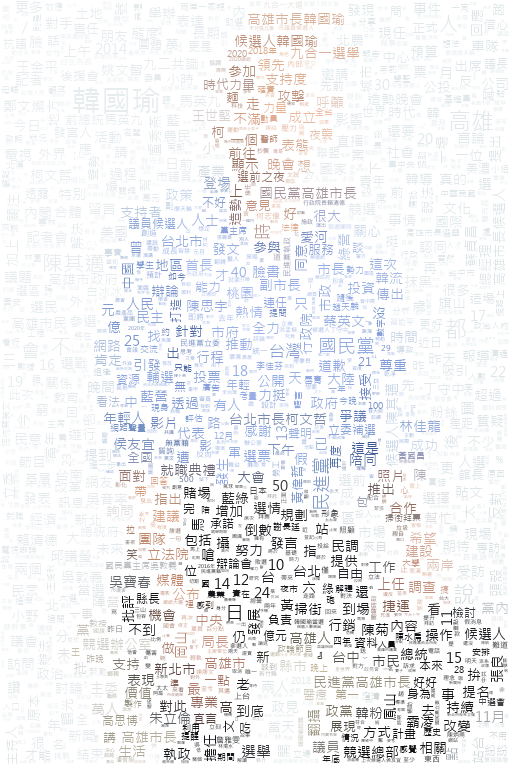

In [13]:
# 韓國瑜
#以韓國瑜的圖為底找出跟蔡英文有關的文章裡個辭彙出現的頻率畫出文字雲
ten_wc = get_wordcloud_of_keywords('韓國瑜', contents, '../politicians/hank.jpg')
# ten_wc.to_file('politicians/tenwc.png')
ten_wc.to_image()

47782


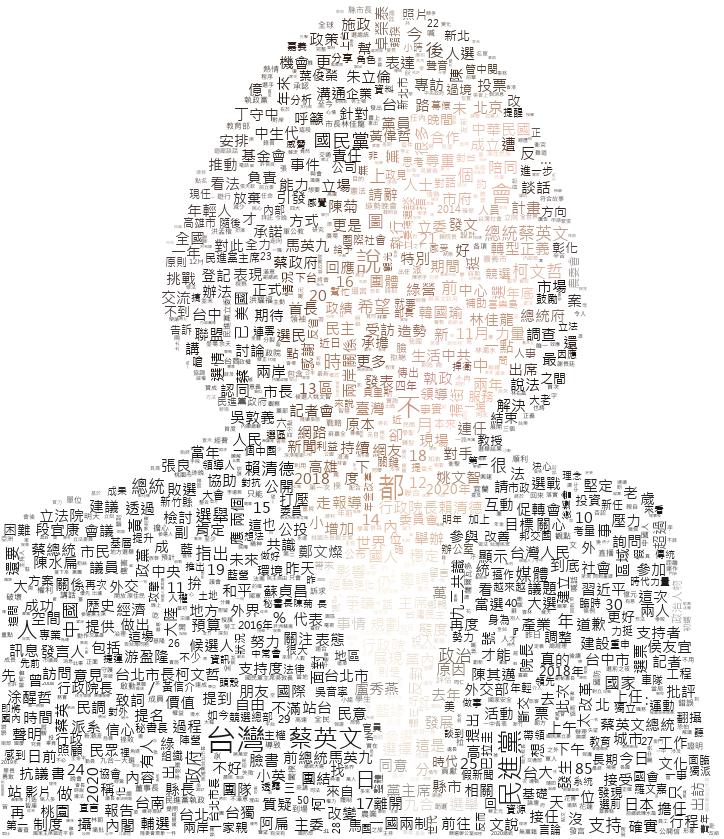

In [14]:
# 蔡英文
#以蔡英文的圖為底找出跟蔡英文有關的文章裡個辭彙出現的頻率畫出文字雲
ten_wc = get_wordcloud_of_keywords('蔡英文', contents, '../politicians/ten.png')
# ten_wc.to_file('politicians/tenwc.png')
ten_wc.to_image()

In [15]:
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 5)

[('台灣', 5039), ('民進黨', 3893), ('蔡英文', 3738), ('中國', 2136), ('國民黨', 2021)]

42597


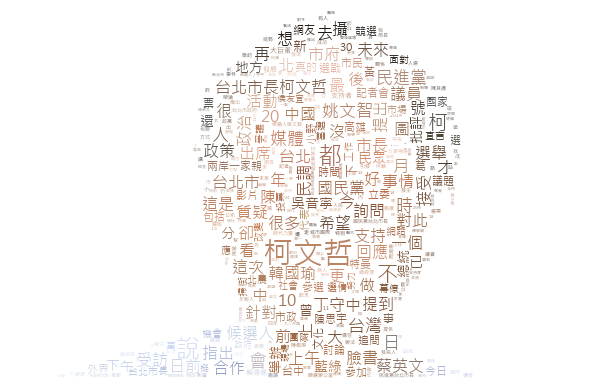

In [16]:
# 柯文哲
#以柯文哲的圖為底找出跟蔡英文有關的文章裡個辭彙出現的頻率畫出文字雲
kp_wc = get_wordcloud_of_keywords('柯文哲', contents, image_path='../politicians/kp.png')
# kp_wc.to_file('politicians/kpwc.png')
kp_wc.to_image()

In [17]:
news_containing_kp = news_containing_keyword('柯文哲', contents)
kp_dict = get_cutted_dict(news_containing_kp)
first_n_words(kp_dict, 5)

[('柯文哲', 8153), ('媒體', 2356), ('姚文智', 2120), ('台灣', 2117), ('民進黨', 2107)]

### get date

In [18]:
date_list = [news['date'] for news in data]
all_date = sorted(list(set(date_list)))
aall_date = [date[5:] for date in all_date][::-1]
date_index = [date_list.index(each_date) for each_date in all_date]
date_index.append(len(date_list)-1)
number_of_news = [date_index[i+1] - date_index[i]-1 for i in range(len(date_index)-1)]
number_of_terms = [sum([sum(data[ni]['cutted_dict'].values()) for ni in range(date_index[i], date_index[i+1])]) for i in range(len(date_index)-1)]

In [37]:
wn_by_day[all_date[0]]

{'辦過': 1.0,
 '官': 1.0,
 '這次': 1.0,
 '工作': 4.0,
 '水果': 3.0,
 '養': 1.0,
 '中心': 1.0,
 '蔡英文': 2.0,
 '加開': 1.0,
 '同意': 1.0,
 '網紅': 2.0,
 '副主席郝龍斌': 1.0,
 '公共運輸': 2.0,
 '服役': 1.0,
 '陸海空軍': 1.0,
 '治理': 2.0,
 '侯友': 1.0,
 '市': 2.0,
 '年輕': 2.0,
 '一段': 1.0,
 '天將': 1.0,
 '保護': 1.0,
 '宿舍': 1.0,
 '廈門': 1.0,
 '不該': 1.0,
 '經費': 1.0,
 '民進黨台北市': 1.0,
 '各界': 1.0,
 '洪耀福': 3.0,
 '農民': 1.0,
 '農友': 1.0,
 '就算': 1.0,
 '查好': 1.0,
 '自行車道': 2.0,
 '解決': 2.0,
 '趕工': 1.0,
 '柯文哲': 2.0,
 '稅後': 1.0,
 '探訪': 1.0,
 '捨': 2.0,
 '前副總統': 1.0,
 '果菜市場': 1.0,
 '會長': 1.0,
 '習慣': 1.0,
 '北農案': 1.0,
 '批吳': 1.0,
 '找': 1.0,
 '15': 2.0,
 '之漢': 2.0,
 '一段時間': 1.0,
 '駐': 1.0,
 '時請': 1.0,
 '儘速': 1.0,
 '依法': 1.0,
 '熟稔': 1.0,
 '協商': 4.0,
 '北農是': 1.0,
 '本來': 1.0,
 '一家': 1.0,
 '關係': 2.0,
 '前總統陳水扁': 2.0,
 '刁難': 1.0,
 '誤會': 1.0,
 '更名': 1.0,
 '已': 3.0,
 '兩岸': 3.0,
 '一連': 1.0,
 '盛產': 1.0,
 '遮陽': 1.0,
 '有沒有': 2.0,
 '台北市長柯文哲': 2.0,
 '侯認': 1.0,
 '公幼': 1.0,
 '形式': 1.0,
 '洪佳君': 1.0,
 '預期': 1.0,
 '預計': 1.0,
 '十足': 1.0,
 '發布聲明': 2.0,
 '態度': 1.0,
 '名譽': 1.

In [30]:
# 每日詞數
wn_by_day = {}
for i in range(len(date_index)-1):
#     print(date_index[i+1])
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict)
#     print(all_date[i])
    wn_by_day[all_date[i]] = current_word_dict

In [31]:
# 每日詞頻
tf_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, divide=number_of_terms[i])
#     print(all_date[i])
    tf_by_day[all_date[i]] = current_word_dict

In [32]:
# 每天出現的字
occur_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, count='occur', divide=number_of_news[i])
#     print(all_date[i])
    occur_by_day[all_date[i]] = current_word_dict

In [33]:
df = pd.DataFrame(wn_by_day)
df = df.fillna(0)

df_tf = pd.DataFrame(tf_by_day)
df_tf = df_tf.fillna(0)

df_occur = pd.DataFrame(occur_by_day)
df_occur = df_occur.fillna(0)

### 畫圖

In [62]:
df.loc['蔡英文']['2018-11-01':]

2018-11-01      3.0
2018-11-02     15.0
2018-11-03      2.0
2018-11-04      6.0
2018-11-05      5.0
2018-11-06      6.0
2018-11-07      4.0
2018-11-08      9.0
2018-11-09      7.0
2018-11-10      4.0
2018-11-11     31.0
2018-11-12      3.0
2018-11-13      6.0
2018-11-14     15.0
2018-11-15     16.0
2018-11-16      6.0
2018-11-17     19.0
2018-11-18     21.0
2018-11-19      3.0
2018-11-20      5.0
2018-11-21     31.0
2018-11-22     14.0
2018-11-23     26.0
2018-11-24     41.0
2018-11-25     28.0
2018-11-26     32.0
2018-11-27     31.0
2018-11-28     65.0
2018-11-29     33.0
2018-11-30     14.0
              ...  
2018-12-24     23.0
2018-12-25     22.0
2018-12-26     14.0
2018-12-27     25.0
2018-12-28     71.0
2018-12-29      3.0
2018-12-30      2.0
2018-12-31     11.0
2019-01-01     39.0
2019-01-02     58.0
2019-01-03    170.0
2019-01-04    122.0
2019-01-05     19.0
2019-01-06     48.0
2019-01-07     71.0
2019-01-08     41.0
2019-01-09     27.0
2019-01-10     40.0
2019-01-11     69.0


In [58]:
date=df.loc['蔡英文'].index.to_datetime()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  """Entry point for launching an IPython kernel.


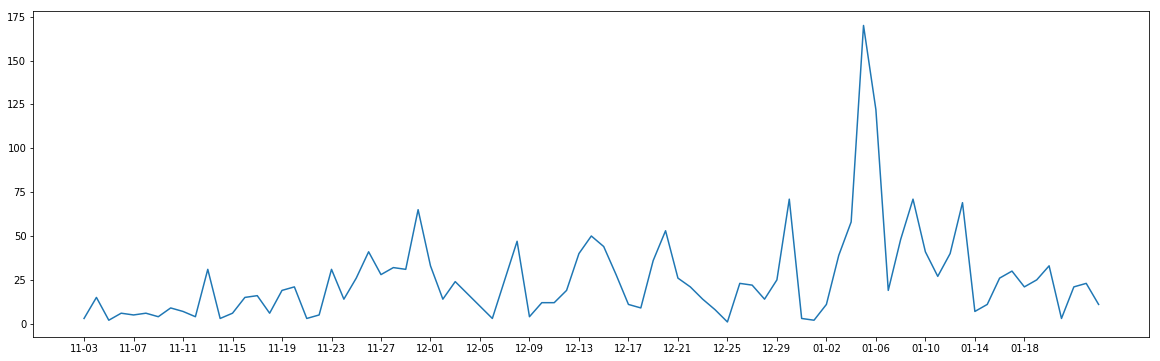

In [65]:
# word times
plt.figure(figsize=(20,6))
plt.plot(df.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.show()

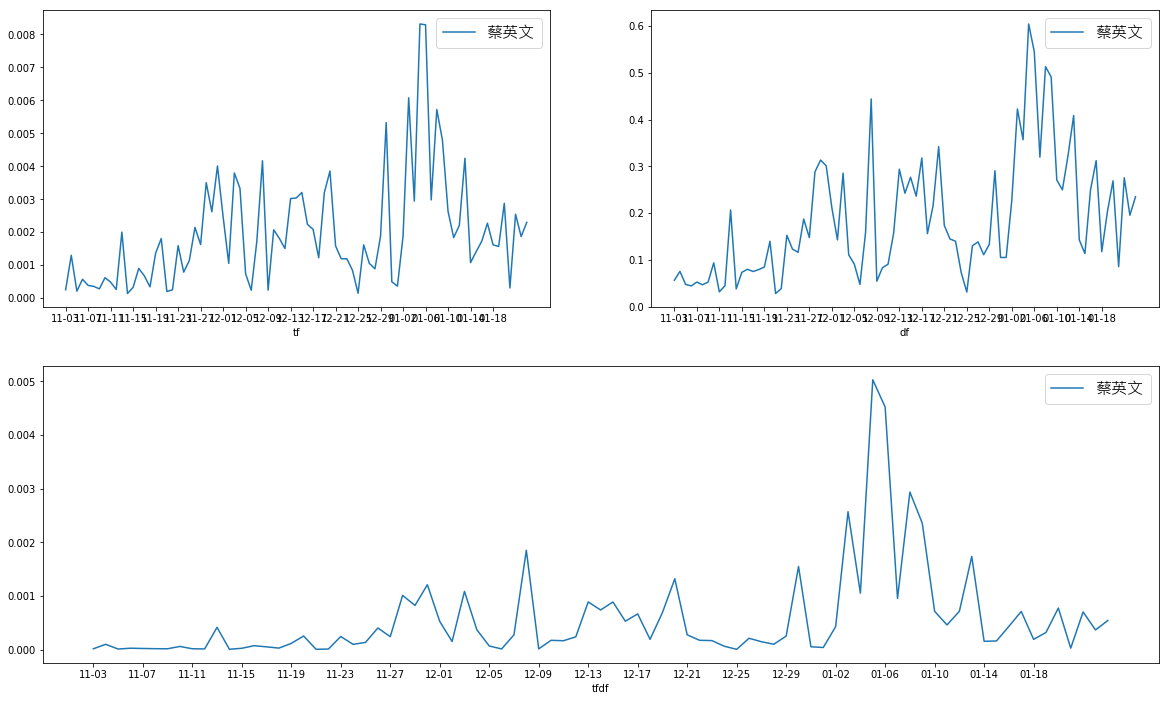

In [66]:
plt.figure(figsize=(20,12))

font = font_manager.FontProperties(fname='../tools/msjh.ttc',
                               weight='bold',
                               style='normal', size=16)

plt.subplot(2,2,1)
plt.plot(aall_date[147:], df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tf')

plt.subplot(2,2,2)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('df')

plt.subplot(2,1,2)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':]*df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tfdf')

plt.show()

In [92]:
def plot_tfdf_of_word(word, df_tf, df_occur, date_from='2018-06-07', date_to='2019-01-22'):
    from_index = df_tf.columns.get_loc(date_from)
    to_index = df_tf.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25
    font = font_manager.FontProperties(fname='../tools/msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    plt.plot(aall_date[from_index:to_index], 
             df_tf.loc[word][date_from:date_to]*df_occur.loc[word][date_from:date_to], '-o', label=word)
    plt.legend(prop=font)
    plt.xticks(list(range(0, date_length, date_int)), [aall_date[::-1][from_index:to_index][i] for i in range(0, date_length, date_int)])

In [160]:
def find_corr(word, df_tf):
    data_merge=pd.DataFrame()
    for i in range(len(word)):
        data_merge=pd.concat([data_merge,df_tf.loc[word[i]]],axis=1)
    corr=data_merge.corr()
    f, ax = plt.subplots(figsize = (6,4))
    cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.6, as_cmap = True)
    sns.heatmap(corr, linewidths = 0.05, ax = ax, vmax=1, vmin=0, annot=True)
    plt.xticks(range(0, 3), word, fontproperties=font)
    plt.yticks(range(0, 3), word, fontproperties=font)
    plt.show()
    return corr

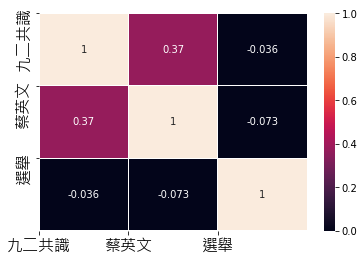

九二共識       蔡英文        選舉
九二共識  1.000000  0.373002 -0.036048
蔡英文   0.373002  1.000000 -0.073411
選舉   -0.036048 -0.073411  1.000000

In [161]:
import seaborn as sns
find_corr(['九二共識','蔡英文','選舉'],df_tf)

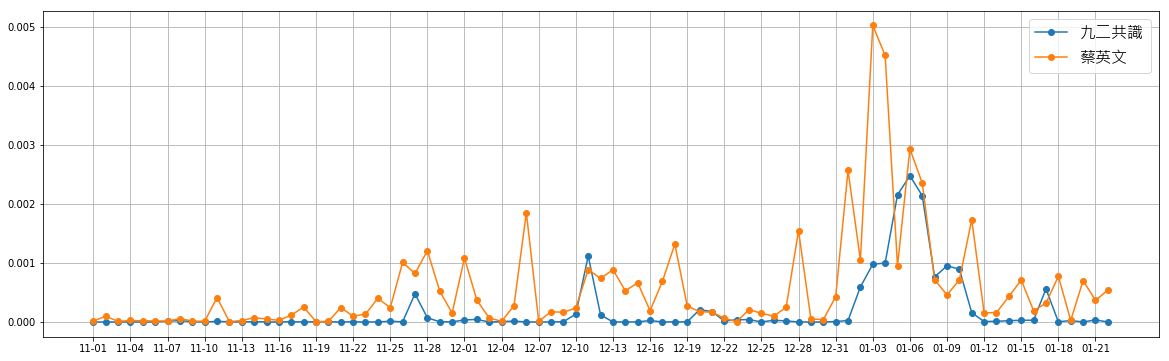

In [131]:
plt.figure(figsize=(20,6))

plot_tfdf_of_word('九二共識', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-22')
plot_tfdf_of_word('蔡英文', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-22')

plt.grid()
plt.show()

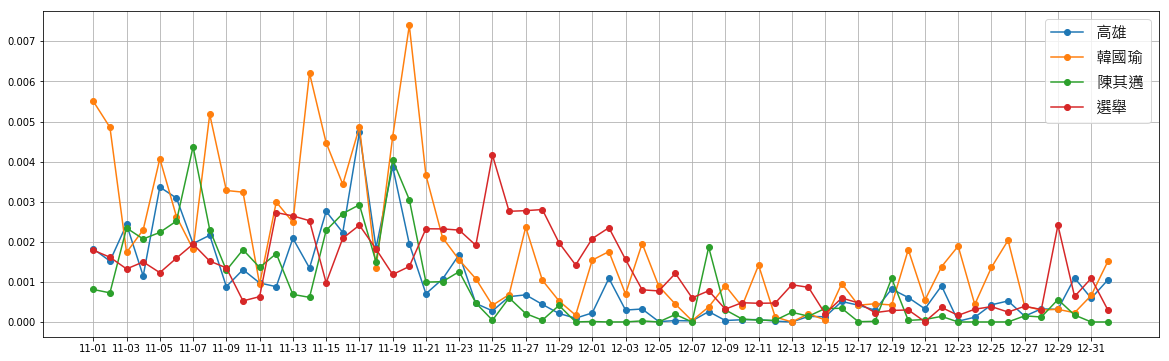

In [94]:
plt.figure(figsize=(20,6))

plot_tfdf_of_word('高雄', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')
plot_tfdf_of_word('韓國瑜', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')
plot_tfdf_of_word('陳其邁', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')
plot_tfdf_of_word('選舉', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')

plt.grid()
plt.show()

### 大事件被討論的時間區段與聲量

In [102]:
def get_high_tfdf_date(word, df_tf, df_occur):
    tfdf = get_tfdf(word, df_tf, df_occur)
    m = statistics.mean(tfdf)
    s = statistics.stdev(tfdf)
    tfdf_bool = [x > m+s for x in tfdf]
    tfdf_date = {all_date[x[0]]: tfdf[x[0]] for x in list(filter(lambda e: e[1], enumerate(tfdf_bool)))}
    return tfdf_date

def draw_event(event, i, df_tf, df_occur):
    event_date = get_high_tfdf_date(event, df_tf, df_occur)
    date_index = [all_date.index(x) for x in event_date.keys()]
    plt.scatter(date_index, [i for x in date_index], s=[x*100000 for x in list(event_date.values())])

In [103]:
event_high_tfdf_dict = {e: get_high_tfdf_date(e, df_tf, df_occur) for e in events}
event_high_tfdf_dict['九二共識']

{'2018-11-27': 0.00047779497618490654,
 '2018-12-11': 0.0011198556630478739,
 '2019-01-02': 0.00059487536635617101,
 '2019-01-03': 0.00097852145408288045,
 '2019-01-04': 0.0010009700759377913,
 '2019-01-05': 0.0021587700031377474,
 '2019-01-06': 0.0024804303707760202,
 '2019-01-07': 0.0021426805483064585,
 '2019-01-08': 0.00076373997591281631,
 '2019-01-09': 0.00095328884652049557,
 '2019-01-10': 0.00089578978799641695,
 '2019-01-17': 0.0005606260193200352}

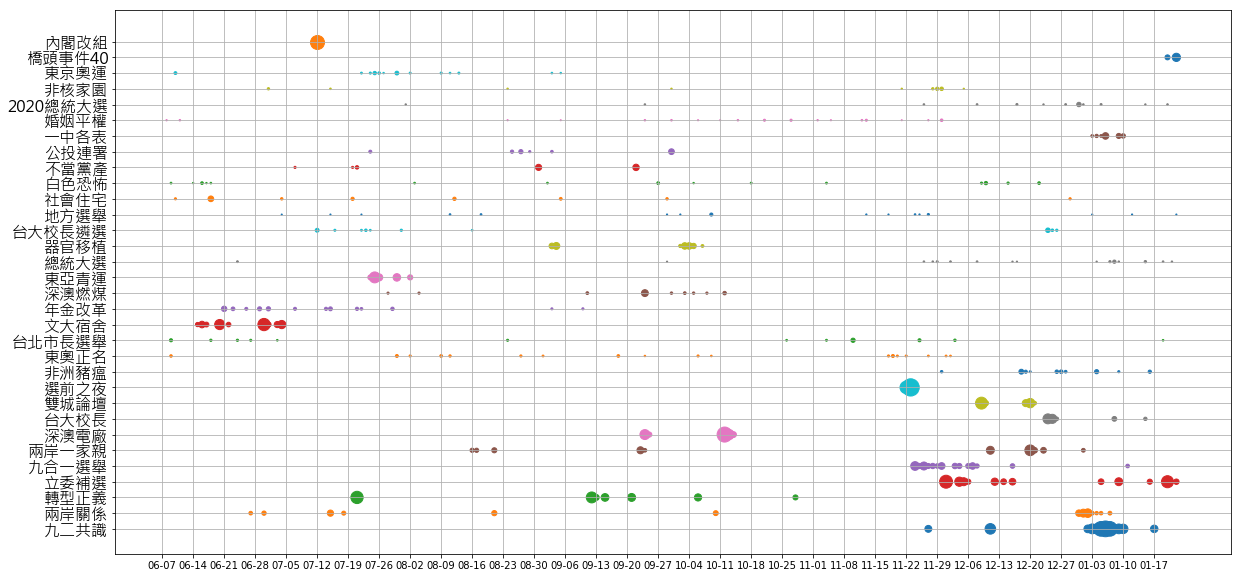

In [105]:
plt.figure(figsize=(20, 10))
for (i, e) in enumerate(events):
    draw_event(e, i, df_tf, df_occur)
# plt.xticks(range(0, 230), all_date)
plt.xticks(list(range(0, 230, 7)), [aall_date[::-1][i] for i in range(0, 230, 7)])
plt.yticks(range(0, 32), events, fontproperties=font)

plt.grid()
plt.show()

In [107]:
# each event with tfdf of related people
event_people_dict = {}
for event in events:
    event_data = data_containing_keyword(event, data)
    # event_data[0]
    name_times_of_date = {}
    for date in all_date:
        oneday_data = list(filter(lambda data: data['date']==date, event_data))
        oneday_dict = [news['cutted_dict'] for news in oneday_data]
        current_word_dict = merge_one_day_news_dict(oneday_dict, 'wt', divide=len(oneday_data))
        possible_name = first_n_words(current_word_dict, 10000, 3, 3)
        name_times_of_date[date]= list(filter(lambda x: x[0] in names, possible_name))

    all_names = set([name for name_list in name_times_of_date.values() for (name, times) in name_list])
    event_people_dict[event] = {name: [dict(name_times_of_date[date]).get(name, 0) for date in all_date] for name in all_names}
    
# with open('../data/event_people_dict.json', 'w', encoding='utf-8') as j:
#     json.dump(event_people_dict, j)

In [108]:
pd.DataFrame(event_people_dict).T.head(3)

丁允恭  \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
一中各表                                                    NaN   
不當黨產                                                    NaN   

                                                        丁守中  任美鈴  \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  NaN   
一中各表      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  NaN   
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  NaN   

                                                        何孟樺  \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
一中各表      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                        何志偉  何瑞英  余登發  \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  NaN  NaN   
一中各表      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  NaN  NaN   
不當黨產                                                    NaN  NaN  NaN   

                                                        侯友宜  \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
一中各表                                                    NaN   
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                        劉世芳  \
2020總統大選                                                NaN   
一中各表                                                    NaN   
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                        劉奕霆 ...   \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... ...    
一中各表                                                    NaN ...    
不當黨產                                                    NaN ...    

                                                        高思博  \
2020總統大選                                                NaN   
一中各表                                                    NaN   
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                        高育仁  \
2020總統大選                                                NaN   
一中各表                                                    NaN   
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                        魏明谷  黃信介  \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  NaN   
一中各表                                                    NaN  NaN   
不當黨產                                                    NaN  NaN   

                                                        黃偉哲  \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
一中各表                                                    NaN   
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                        黃國昌  \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
一中各表      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                        黃士修  \
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
一中各表                                                    NaN   
不當黨產                                                    NaN   

                                                        黃敏惠  \
2020總統大選                                                NaN   
一中各表      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                        黃瀞瑩  黃韋鈞  
2020總統大選  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  NaN  
一中各表                                                    NaN  NaN  
不當黨產      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  NaN  

[3 rows x 280 columns]

In [109]:
people_tfdf_dict = {name: list(get_tfdf(name, df_tf, df_occur)) for name in names}

In [110]:
pd.DataFrame(people_tfdf_dict, index=aall_date).T.head(4)

01-22     01-21  01-20    01-19  01-18  01-17     01-16     01-15  \
丁允恭    0.0  0.000000    0.0  0.00000    0.0    0.0  0.000000  0.000000   
丁守中    0.0  0.000237    0.0  0.00014    0.0    0.0  0.000006  0.000003   
任美鈴    0.0  0.000000    0.0  0.00000    0.0    0.0  0.000011  0.000000   
何孟樺    0.0  0.000000    0.0  0.00000    0.0    0.0  0.000000  0.000000   

        01-14     01-13  ...    06-16     06-15     06-14  06-13  06-12  \
丁允恭  0.000000  0.000000  ...      0.0  0.000006  0.000000    0.0    0.0   
丁守中  0.000119  0.000072  ...      0.0  0.000010  0.000024    0.0    0.0   
任美鈴  0.000000  0.000000  ...      0.0  0.000000  0.000000    0.0    0.0   
何孟樺  0.000000  0.000000  ...      0.0  0.000000  0.000000    0.0    0.0   

        06-11     06-10  06-09  06-08  06-07  
丁允恭  0.000000  0.000000    0.0    0.0    0.0  
丁守中  0.000002  0.000003    0.0    0.0    0.0  
任美鈴  0.000000  0.000000    0.0    0.0    0.0  
何孟樺  0.000000  0.000000    0.0    0.0    0.0  

[4 rows x 230 columns]

# Part III 視覺化呈現研究結果

In [83]:
# import packages
import math
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import clear_output
from datetime import datetime, timedelta
import json

#### Section I 政治事件網路聲量分析

In [84]:
def get_scatter_trace(points_x, points_y, points_size=10, trace_name='', line=False):
    if line:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'lines',
            hoverinfo = 'x+y',
            name
            = trace_name,
            text = points_size,
            yaxis = 'y2',
            line = {
                "color": 'rgba(255, 166, 87, 0.4)'
            }
        )
    else:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'markers' if not line else 'lines',
            marker = {
                'size': points_size
            },
            hoverinfo = 'text+name',
            name = trace_name,
            text = points_size
        )

In [85]:
events = json.loads(open('../data/event_tfdf_dict.json').read())

In [94]:
def sectionI_plot(ori_data, title=''):
    
    # data
    fig_data = []
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for date, tfdf_val in ori_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(ori_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    display(py.iplot(fig, filename='bubble-event'))

In [95]:
from IPython.display import display
sectionI_plot(events)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

#### Section II 事件相關人聲量分析

In [91]:
event_people_relation = json.loads(open('../data/event_people_dict.json').read())

In [92]:
def sectionII_plot(event_name, ori_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    # data
    fig_data = []
    x, y, size = [], [], []
    for date, tfdf_val in events[event_name].items():
        x.append(datetime.strptime(date, "%Y-%m-%d"))
        y.append(len(ori_data) + 1)
        size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
    fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=event_name))
        
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for day_index, tfdf_val in enumerate(ori_data[name]):
            if tfdf_val != 0:
                x.append(start_date + timedelta(days=day_index))
                y.append(len(ori_data) - index)
                size.append(max(math.log(round(tfdf_val, 2))*10,0)) ## constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='People'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)

    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='event-people'))


In [93]:
event_selector = widgets.Dropdown(
    options=list(events.keys()),
    description='政治事件：'
)
display(event_selector)

def event_change(change):
    top_10_related_people = dict(sorted(event_people_relation[change['new']].items(), key=lambda x: sum(x[1]), reverse=True)[:10])
    sectionII_plot(change['new'], top_10_related_people, event_selector, title=change['new'])

event_change({'new': list(events.keys())[0]})
    
event_selector.observe(event_change, names='value')

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

#### Section III 人物聲量與事件疊圖分析

In [47]:
people = json.loads(open('../data/people_tfdf_dict.json').read())

In [55]:
def sectionIII_plot(people_data, events_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    fig_data = []
    
    # people data
    x, y = [], []
    for day_index, value in enumerate(people_data['tfdf']):
        x.append(start_date + timedelta(days=day_index))
        y.append(value)
    fig_data.append(get_scatter_trace(x, y, line=True))
    
    # event data
    for index, name in enumerate(events_data):
        x, y, size = [], [], []
        for date, tfdf_val in events_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(events_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        ),
        yaxis2=dict(
            title='People Reputation',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    
    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='person-events'))

In [56]:
people_selector = widgets.Dropdown(
    options=list(people.keys()),
    description='政治人物：'
)
display(people_selector)

def people_change(change):
    sectionIII_plot({
        'name': change['new'],
        'tfdf': people[change['new']]
    }, events, people_selector, title='人物與事件聲量圖({})'.format(change['new']))

people_change({'new': list(people.keys())[0]})
    
people_selector.observe(people_change, names='value')


Dropdown(description='政治人物：', options=('柯文哲', '韓國瑜', '陳其邁', '蔡英文', '蘇貞昌', '姚文智', '侯友宜', '丁守中', '賴清德', '馬英九', '…

### Visualization
[Section I 政治事件網路聲量分析](https://plot.ly/~a136489/67)

[Section II 事件相關人聲量分析](https://plot.ly/~a136489/69/#/)

[Section III 人物聲量與事件疊圖分析](https://plot.ly/~a136489/71)
